In [1]:
import numpy as np
import networkx as nx
import torch
from torch_geometric.data import Data
import time

import random
from torch_geometric.utils import from_networkx

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from torch_geometric.nn import SAGEConv

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn.functional as F

import sys
sys.path.insert(1,'../src')
from DataLoader_rad_grid import RGGDataset_grid
from TwoLayerGraphSage import GCN, cGCN
from Utils import *

import os.path as osp

from torch_geometric.data import Dataset, download_url


import os

/home/math/maskey/anaconda3/envs/pyg_cuda102/lib/python3.8/site-packages/torch_geometric/data/storage.py:244: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
09:50:06|TQ-INFO| Initializing torchquad.


In [2]:
DL = RGGDataset_grid(root = '../../input_rad')

dataset = DL.get(1,2**5)

In [3]:
positions = torch.load('../../input_rad/raw/grid_positions_128.pt')

In [4]:
model = GCN()
model.load_state_dict(torch.load( '../models/GCNTwoLayersGraphSage'))

cGCNN = cGCN()
cGCNN.load_state_dict(torch.load( '../models/cGCNTwoLayersGraphSage'))

<All keys matched successfully>

In [5]:
N = 14

In [6]:
def error_fct(radius, signal):
    L2Errors = []

    cdata = DL.get(radius,2**N)
    cpos = positions[-1]

    cdata.x = signal 

    output = model.forward(cdata)

        
    for i in range(1, N):
        start = time.time()
        data = DL.get(radius, 2**i) 
        pos = positions[i-1]
        signal = cdata.x[pos[1].type(torch.LongTensor)]
        signal = torch.reshape(signal,( len(signal),1))
        data.x = signal # + (0.01**0.5)*torch.randn(len(signal),1) #random noise

        nodeErrors = output[pos[1].type(torch.LongTensor)] - model.forward(data)
        L2Error = torch.sqrt(1/len(nodeErrors)*torch.sum(torch.pow(nodeErrors,2)))
        L2Errors.append(L2Error)
        end = time.time()
        print(f"{i}: Took {(end-start)* 1000.0:.3f} ms")

    err = [x.detach().numpy() for x in L2Errors]

    return err

In [7]:
def create_randn_bandlimited(gridsize=256, sup=20, ampl=3):
    #gridsize=int(gridsize)
    #sup=int(sup) 
    #ampl=int(ampl)
    support = torch.randn(sup, sup, dtype=torch.complex64) #we create the support of the signal in Fourier domain
    square = torch.zeros(gridsize,gridsize,dtype = torch.complex64)
    square[:sup,-sup:] = support
    square[:ampl,-ampl:]  =  square[:ampl,-ampl:]*100
    ifft2 = torch.fft.ifft2(square) #now we have the signal in time domain 
    ifft2_real = ifft2.real
    return ifft2_real

In [8]:
def plot_fct(fct, gridsize=256):
    """
    fct is a grid
    """
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    X = np.arange(0, 1, 1/gridsize)
    Y = np.arange(0, 1, 1/gridsize)
    X, Y = np.meshgrid(X, Y)
    Z = fct.detach().numpy()

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

In [9]:
def fct_eval(fct, pos): 
    """
    For evaluating the signal we got above in a vector in [0,1]^2. The idea is that the IFFT gives us a 256x256
    grid. For every 2D vector, we check by the above calculations in which grid-patch it lies and then
    evealuate the signal we receive by IFFT in it.
    """
    
    i = pos[0][:,0]*257-1
    i = i.type(torch.LongTensor) 
    j = pos[0][:,1]*257-1
    j = j.type(torch.LongTensor)
    return fct[i,j]

In [10]:
ifft2_real = create_randn_bandlimited()
signal = fct_eval(ifft2_real, positions[-1]).reshape(2**N,1) #evaluation in all vectors we sampled
errs = [ ]
for i in [1, 5, 9]:
    errs.append(error_fct(i, signal))

1: Took 15.127 ms
2: Took 16.995 ms
3: Took 49.406 ms
4: Took 35.115 ms
5: Took 7.094 ms
6: Took 46.969 ms
7: Took 67.775 ms
8: Took 46.287 ms
9: Took 176.322 ms
10: Took 797.723 ms
11: Took 131.501 ms
12: Took 176.533 ms
13: Took 535.785 ms
1: Took 19.305 ms
2: Took 17.602 ms
3: Took 18.310 ms
4: Took 65.572 ms
5: Took 15.694 ms
6: Took 20.569 ms
7: Took 4.421 ms
8: Took 51.251 ms
9: Took 118.312 ms
10: Took 176.479 ms
11: Took 414.672 ms
12: Took 1129.572 ms
13: Took 4178.736 ms
1: Took 12.577 ms
2: Took 14.049 ms
3: Took 14.136 ms
4: Took 20.785 ms
5: Took 17.314 ms
6: Took 11.591 ms
7: Took 12.033 ms
8: Took 45.773 ms
9: Took 117.722 ms
10: Took 137.138 ms
11: Took 483.036 ms
12: Took 1448.971 ms
13: Took 6996.847 ms


for i in [1,5,9]:
    start = time.time()
    error = [0 for x in range(1)]
    for i in range(1):
        error = [sum(x) for x in zip(error, error_fct(i, signal))]
        #error = error + error_fct(i, signal) 
    errs.append(error/1)
    end = time.time()
    print(str(i) + ": " +  str((end-start)*1000))

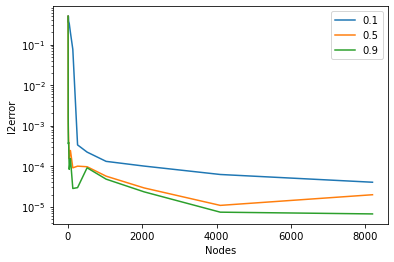

In [11]:
xAxis = [2**n for n in range(1,14)]
fig = plt.figure()
plt.xlabel('Nodes')
plt.ylabel('l2error')
plt.yscale('log')
#txt="radius: " + str((radius)/10)
#plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=15)
plt.plot(xAxis,errs[0],label='0.1')
plt.plot(xAxis,errs[1], label='0.5')
plt.plot(xAxis,errs[2],label='0.9')
plt.legend()
#fig.savefig('../output/l2Error' + str(1002) + 'Nodes.png', dpi=fig.dpi)

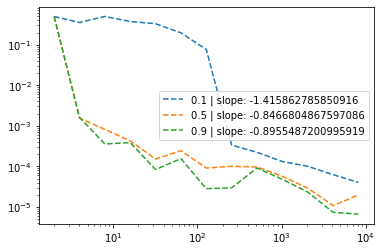

In [12]:
slope0, intercept0 = np.polyfit(np.log(xAxis), np.log(errs[0]), 1)
slope1, intercept1 = np.polyfit(np.log(xAxis), np.log(errs[1]), 1)
slope2, intercept2 = np.polyfit(np.log(xAxis), np.log(errs[2]), 1)


#txt="radius: " + str((radius)/10) + "  |  slope: " + str(slope)
#plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=15)
plt.loglog(xAxis[:],errs[0], '--', label = '0.1 | slope: ' + str(slope0))
plt.loglog(xAxis[:],errs[1], '--', label = '0.5 | slope: ' + str(slope1))           
plt.loglog(xAxis[:],errs[2], '--', label = '0.9 | slope: ' + str(slope2))           
plt.legend()

#fig.savefig('../output/Logl2Error' + str(1002) + 'Nodes.png', dpi=fig.dpi)

0 1
1: Took 4.954 ms
2: Took 5.185 ms
3: Took 4.583 ms
4: Took 5.157 ms
5: Took 4.708 ms
6: Took 5.611 ms
7: Took 6.492 ms
8: Took 10.380 ms
9: Took 12.783 ms
10: Took 41.768 ms
11: Took 41.119 ms
12: Took 135.700 ms
13: Took 255.617 ms
14: Took 1014.909 ms
1 5
1: Took 8.876 ms
2: Took 9.947 ms
3: Took 15.809 ms
4: Took 13.272 ms
5: Took 15.966 ms
6: Took 16.396 ms
7: Took 7.025 ms
8: Took 14.228 ms
9: Took 26.952 ms
10: Took 102.383 ms
11: Took 246.134 ms
12: Took 1102.827 ms
13: Took 4834.399 ms
14: Took 20524.353 ms
2 9
1: Took 10.471 ms
2: Took 9.118 ms
3: Took 6.915 ms
4: Took 5.202 ms
5: Took 9.143 ms
6: Took 11.872 ms
7: Took 12.272 ms
8: Took 26.750 ms
9: Took 44.565 ms
10: Took 150.344 ms
11: Took 534.569 ms
12: Took 1914.601 ms
13: Took 9583.286 ms
14: Took 45125.978 ms
0: 164154.7293663025


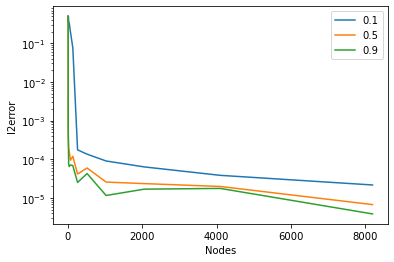

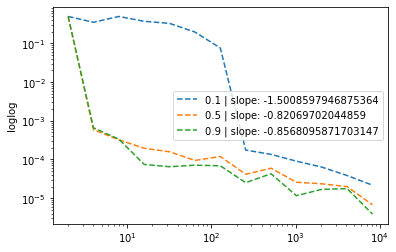

In [19]:
"""
We created a dataset with graphs of size 2^1,2^2,..,2^15,2^16. This data set is saved in //home/groups/ai/maskey/input_rad/processed. A graph of size n and constructed with radius r, can be read out by "DL.get(10*r,n)" after constructing the Data loader object, e.g. "DL = RGGDataset_grid(root = '../../input_rad')".

Then, we use the finest graph(size 2^16) as the continuous limit object and calculate graph wise l^2 errors with some graph signal. 

"""

import numpy as np
import torch
from torch_geometric.data import Data #for constructing data/graph objects from the sample points
import time

import random

import matplotlib.pyplot as plt

from torch_geometric.nn import SAGEConv #used for the model construction
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn.functional as F

import sys
sys.path.insert(1,'../src')
from DataLoader_rad_grid import RGGDataset_grid #This is the class to load data
from TwoLayerGraphSage import GCN #This is our MPNN

import os.path as osp

from torch_geometric.data import Dataset, download_url

import os

import pickle #for saving

#DL = RGGDataset_grid(root = '../../input_rad')

#dataset = DL.get(1,2**5)

#load the positions, list of positions for all graphs
positions = torch.load('../../input_rad/raw/grid_positions_128.pt')

model = GCN()
model.load_state_dict(torch.load( '../models/GCNTwoLayersGraphSage'))

N = 14


def create_randn_bandlimited(gridsize=256, sup=20, ampl=3):
    #gridsize=int(gridsize)
    #sup=int(sup) 
    #ampl=int(ampl)
    support = torch.randn(sup, sup, dtype=torch.complex64) #we create the support of the signal in Fourier domain
    square = torch.zeros(gridsize,gridsize,dtype = torch.complex64)
    square[:sup,-sup:] = support
    square[:ampl,-ampl:]  =  square[:ampl,-ampl:]*100
    ifft2 = torch.fft.ifft2(square) #now we have the signal in time domain 
    ifft2_real = ifft2.real
    return ifft2_real

def fct_eval(fct, pos): 
    """
    For evaluating the signal we got above in a vector in [0,1]^2. The idea is that the IFFT gives us a 256x256
    grid. For every 2D vector, we check by the above calculations in which grid-patch it lies and then
    evealuate the signal we receive by IFFT in it.
    """
    
    i = pos[0][:,0]*257-1
    i = i.type(torch.LongTensor) 
    j = pos[0][:,1]*257-1
    j = j.type(torch.LongTensor)
    return fct[i,j]

def error_fct(radius, signal):
    """
    Calculates for a given radius and signal the error between the coarser graphs and finest graph
    
    """
    DL = RGGDataset_grid(root = '../../input_rad', radius= radius/10,size = 7)
    DL.process_grid()
    
    L2Errors = []

    cdata = DL.get(radius,2**N)
    cpos = positions[-1]

    cdata.x = signal 

    output = model.forward(cdata)

        
    for i in range(1, N):
        data = DL.get(radius, 2**i) 
        pos = positions[i-1]
        signal = cdata.x[pos[1].type(torch.LongTensor)]
        signal = torch.reshape(signal,( len(signal),1))
        data.x = signal # + (0.01**0.5)*torch.randn(len(signal),1) #random noise

        nodeErrors = output[pos[1].type(torch.LongTensor)] - model.forward(data)
        L2Error = torch.sqrt(1/len(nodeErrors)*torch.sum(torch.pow(nodeErrors,2)))
        L2Errors.append(L2Error)

    err = [x.detach().numpy() for x in L2Errors]

    return err

errs = [ [0]*2**N, [0]*2**N, [0]*2**N]

#low_pass = lambda x:  (1+(torch.tensor(x[:,0]**2 + x[:,1]**2))).pow_(-1)

low_pass = lambda x:  x[:,0]*x[:,1] #the signal

#y = torch.randn(2**N,1)
#cdata = DL.get(1,2**N)
cpos = positions[-1]
signal = low_pass(cpos[0])
signal = torch.reshape(signal,( len(signal),1))
#cdata.x = y 
#signal = y

epochs = 1 #It is a random experiment, How often do we repeat it?

ifft2_real = create_randn_bandlimited()
signal = fct_eval(ifft2_real, positions[-1]).reshape(2**N,1) #evaluation in all vectors we sampled

for j in range(epochs):
    start = time.time()
    ifft2_real = create_randn_bandlimited()
    signal = fct_eval(ifft2_real, positions[-1]).reshape(2**N,1) 
    #error = [ , , , ]
    for i, value in enumerate([1,5,9]):    
        errs[i] = [sum(x) for x in zip(errs[i], error_fct(value, signal))]
        #error = error + error_fct(i, signal) 
        errs[i] = [x/epochs for x in errs[i]]
        #errs.append([x/epochs for x in error_fct(i, signal)])
    #errs = [sum(x) for x in zip(errs, errs)]
    end = time.time()
    print(str(j) + ": " +  str((end-start)*1000))
    
with open('../output/BLRandnSignalGraphSage2MLP' + str(2**N) + 'Nodes' + '.pickle', 'wb') as output:
    pickle.dump(errs, output)
    
    
    
xAxis = [2**n for n in range(1,N)]
fig = plt.figure()
plt.xlabel('Nodes')
plt.ylabel('l2error')
plt.yscale('log')
#txt="radius: " + str((radius)/10)
#plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=15)
plt.plot(xAxis,errs[0],label='0.1')
plt.plot(xAxis,errs[1], label='0.5')
plt.plot(xAxis,errs[2],label='0.9')
plt.legend()
fig.savefig('../output/BLRandnSignalGraphSage2MLPl2Error' + str(2**N) + 'Nodes.png', dpi=600)
plt.show()

slope0, intercept0 = np.polyfit(np.log(xAxis), np.log(errs[0]), 1)
slope1, intercept1 = np.polyfit(np.log(xAxis), np.log(errs[1]), 1)
slope2, intercept2 = np.polyfit(np.log(xAxis), np.log(errs[2]), 1)



xAxis = [2**n for n in range(1,N)]
fig = plt.figure()
#plt.xlabel('Nodes')
plt.ylabel('loglog')
#txt="radius: " + str((radius)/10)
#plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=15)
#txt="radius: " + str((radius)/10) + "  |  slope: " + str(slope)
#plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=15)
plt.loglog(xAxis[:],errs[0], '--', label = '0.1 | slope: ' + str(slope0))
plt.loglog(xAxis[:],errs[1], '--', label = '0.5 | slope: ' + str(slope1))           
plt.loglog(xAxis[:],errs[2], '--', label = '0.9 | slope: ' + str(slope2))           
plt.legend()

fig.savefig('../output/BLRandnSignalGraphSage2MLPLogl2Error' + str(2**N) + 'Nodes.png', dpi=600)
plt.show()
